# Benchmark Finetuned Models With the WikiSQL Test Split

Once some models have been successfully been finetuned with the model-finetune-wikiSQL notebook, their training and testing performance can be analyzed here. See information about them, such as how much memory was required, time to complete inference testing, and exact match between queries generated by models and reference labels.

In [1]:
#provide your token
huggingface_token = ""

In [2]:
! nvidia-smi

Fri Apr 11 18:26:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  |   00000000:01:00.0  On |                  N/A |
| 72%   52C    P8             27W /  350W |     968MiB /  12288MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
cuda = torch.cuda.is_available()
print(cuda)  # print True if GPU is available
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3080


## Imports and Finetuned Models to Be Included in Cross Comparison

In [4]:
from huggingface_hub import login
from datasets import load_dataset, DatasetDict
import evaluate
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import time

login(token=huggingface_token)

model_info = [{'name': 't5-small', 'path': 'finetuned/t5-small-wikisql', 'batch_size': 256},
              {'name': 'Salesforce/codet5-small', 'path': 'finetuned/codet5-small-wikisql', 'batch_size': 256},
              {'name': 'facebook/bart-base', 'path': 'finetuned/bart-base-wikisql', 'batch_size': 64},
              {'name': 'Salesforce/codet5-base', 'path': 'finetuned/codet5-base-wikisql', 'batch_size': 256}]


## Format Test Split Data

In [5]:
dataset = DatasetDict({ 'test': load_dataset('wikisql', split='test') })

def format_dataset(example):
    return {'input': 'translate to SQL: ' + example['question'], 'target': example['sql']['human_readable']}

formatted_test_dataset = dataset.map(format_dataset, remove_columns=dataset['test'].column_names)

print("DatasetDict class details: \n", formatted_test_dataset, "\n", "First formatted example: \n", formatted_test_dataset['test'][0])


DatasetDict class details: 
 DatasetDict({
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 15878
    })
}) 
 First formatted example: 
 {'input': "translate to SQL: What is terrence ross' nationality", 'target': 'SELECT Nationality FROM table WHERE Player = Terrence Ross'}


## Pipeline to Run Testing Battery Between Models

It may be necessary to monitor system resources while running the following code cell. Using torch to clean up memory is not always perfect, which may result in overshooting the limits of dedicated memory. 

In [6]:
# function to process testing data for finetuned models
def wikiSQL_testing_pipeline():
    cuda = torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")

    # Metric calculation 
    # Exact Match https://huggingface.co/spaces/evaluate-metric/exact_match
    # ROUGE2 score https://huggingface.co/spaces/evaluate-metric/rouge
    # BLEU score https://huggingface.co/spaces/evaluate-metric/sacrebleu
    exact_match = evaluate.load("exact_match")
    rouge = evaluate.load("rouge")
    sacrebleu = evaluate.load("sacrebleu")

    metrics_dict = {}

    for info in model_info:
        
        path = info['path']
        batch_size = info['batch_size']

        tokenizer = AutoTokenizer.from_pretrained(path)
        model = AutoModelForSeq2SeqLM.from_pretrained(path)

        model.to(device)

        def translate_to_sql(batch):    
            inputs = tokenizer(batch['input'], truncation=True, padding='max_length', max_length=256, return_tensors='pt').to(device)
            input_ids = inputs.input_ids
            attention_mask = inputs.attention_mask
            output = model.generate(input_ids, attention_mask=attention_mask, max_length=64)
            predictions = [tokenizer.decode(o, skip_special_tokens=True) for o in output]
            
            return  {'prediction': predictions, 'label': batch['target']}

        # time the inference process by mapping to the DatasetDict
        start = time.time()
        
        results = formatted_test_dataset.map(translate_to_sql, 
                                             remove_columns=formatted_test_dataset['test'].column_names, 
                                             batched=True,
                                             batch_size=batch_size)

        end = time.time()

        predictions, labels = results['test']['prediction'], results['test']['label']
        
        metrics = {
            "exact_match": exact_match.compute(predictions=predictions, references=labels)['exact_match'],
            "rouge2": rouge.compute(predictions=predictions, references=labels)["rouge2"],
            "bleu": sacrebleu.compute(predictions=predictions, references=labels)["score"],
            "inference_time": end - start
        }
        
        metrics_dict[path] = metrics

        # clean up memory
        del model
        if cuda:
            torch.cuda.empty_cache()

    return metrics_dict
        

In [7]:
final_metrics = wikiSQL_testing_pipeline()

final_metrics

Map:   0%|          | 0/15878 [00:00<?, ? examples/s]

Map:   0%|          | 0/15878 [00:00<?, ? examples/s]

Map:   0%|          | 0/15878 [00:00<?, ? examples/s]

Map:   0%|          | 0/15878 [00:00<?, ? examples/s]

{'finetuned/t5-small-wikisql': {'exact_match': 0.2811437208716463,
  'rouge2': 0.7955431850004638,
  'bleu': 66.94452735775545,
  'inference_time': 55.07756233215332},
 'finetuned/codet5-small-wikisql': {'exact_match': 0.3906663307721375,
  'rouge2': 0.8253113077507275,
  'bleu': 73.3629807617083,
  'inference_time': 54.96487259864807},
 'finetuned/bart-base-wikisql': {'exact_match': 0.46126716211109714,
  'rouge2': 0.8654596361731219,
  'bleu': 78.51107965711884,
  'inference_time': 590.576868057251},
 'finetuned/codet5-base-wikisql': {'exact_match': 0.46070034009321076,
  'rouge2': 0.8535379267983898,
  'bleu': 77.85296732210243,
  'inference_time': 167.9024682044983}}

## Construct Comparison Visualizations via Seaborn and Pandas

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

with open("testing_performance.json", "w") as f:
    json.dump(final_metrics, f, indent=4)

# open training output metrics
training_metrics = {}
for model in final_metrics.keys():
    with open(model + "/train_output.json", "r") as f:
        training_metrics[model] = json.load(f)

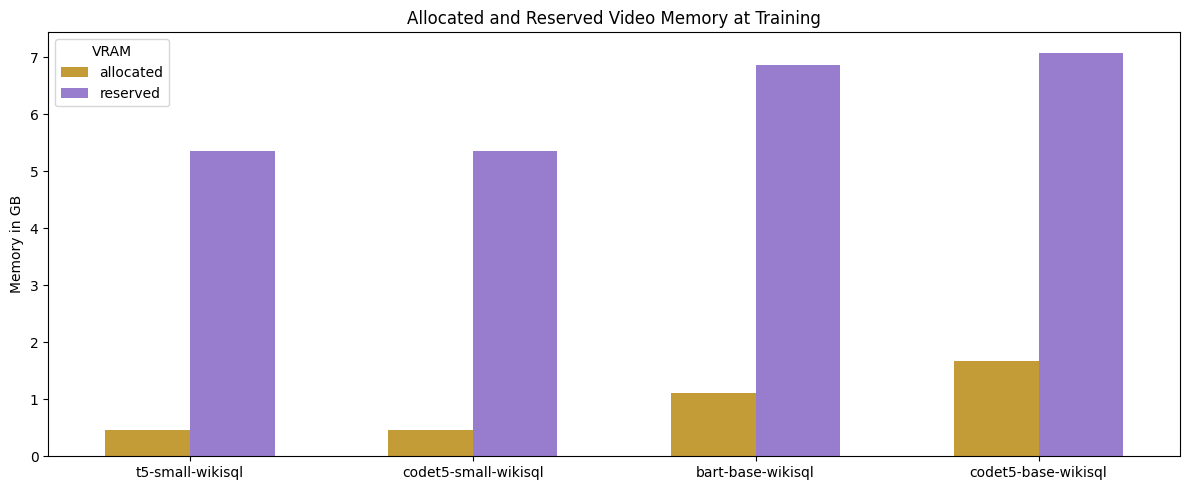

In [9]:
df = pd.DataFrame(training_metrics).T
df.index = df.index.map(lambda x: str(x)[10:])
fig, ax = plt.subplots(figsize=(12, 5))

# Custom bar width and positions
bar_width = 0.3
x = list(range(len(df.index)))  # positions for x-ticks

sns.barplot(data=df['additional_memory_allocated'].to_frame(), x=df.index, y='additional_memory_allocated', ax=ax, color='goldenrod', label='allocated')
sns.barplot(data=df['additional_memory_reserved'].to_frame(), x=df.index, y='additional_memory_reserved', ax=ax, color='mediumpurple', label='reserved')

for i, bar in enumerate(ax.patches[:len(x)]):
    bar.set_width(bar_width)
    bar.set_x(bar.get_x() + .1)

for i, bar in enumerate(ax.patches[len(x):]):
    bar.set_width(bar_width)
    bar.set_x(bar.get_x() + .4)

# Formatting
ax.set_title('Allocated and Reserved Video Memory at Training')
ax.set_ylabel('Memory in GB')
ax.set_xticks(x)  # Set x-ticks to model names
ax.set_xticklabels(df.index)
ax.legend(title='VRAM')

plt.tight_layout()
plt.show()

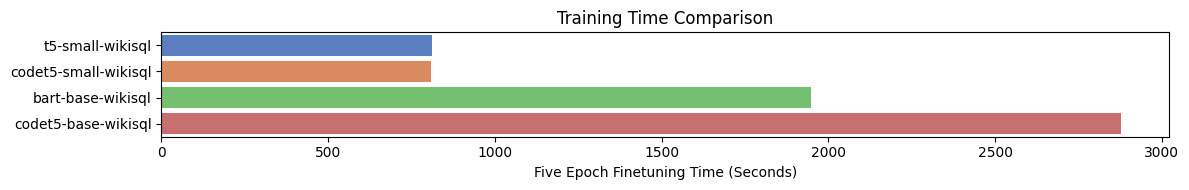

In [10]:
df = pd.DataFrame(training_metrics).T
df.index = df.index.map(lambda x: str(x)[10:])
dft = df.metrics.T.map(lambda x: x['train_runtime']).to_frame()
# hbar for time taken
plt.figure(figsize=(12, 2))
sns.barplot(x=dft.metrics, y=dft.index, orient='h', palette='muted')

plt.title('Training Time Comparison')
plt.xlabel('Five Epoch Finetuning Time (Seconds)')
plt.tight_layout()
plt.show()

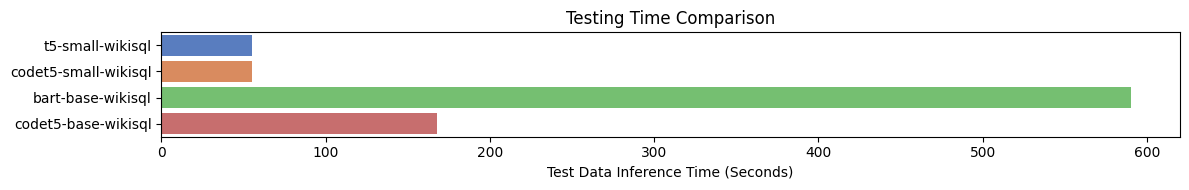

In [11]:
df = pd.DataFrame(final_metrics).T
df.index = df.index.map(lambda x: str(x)[10:])
# hbar for time taken
plt.figure(figsize=(12, 2))
sns.barplot(x=df.inference_time, y=df.index, orient='h', palette='muted')

plt.title('Testing Time Comparison')
plt.xlabel('Test Data Inference Time (Seconds)')
plt.tight_layout()
plt.show()

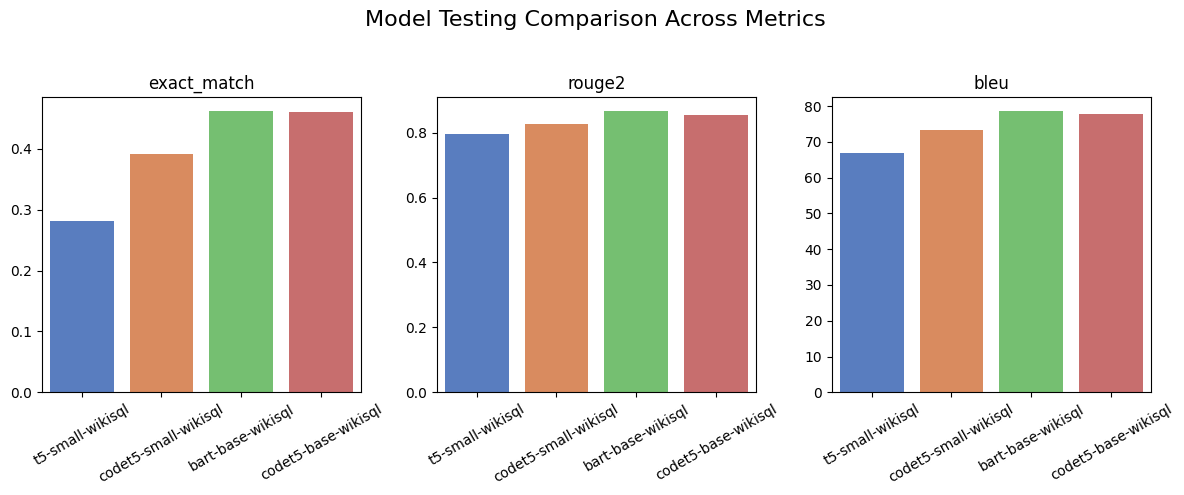

In [12]:
# side by side for main metrics
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

for i, metric in enumerate(df.columns[:3]):
    ax = axes[i]
    subset = df[metric].to_frame()
    sns.barplot(data=subset, x=df.index, y=metric, ax=ax, palette='muted')
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_ylabel('')

plt.suptitle('Model Testing Comparison Across Metrics', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()